In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Load data
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
# test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
# test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# Merge datasets
df_train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
# df_test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
# df_test.columns = df_test.columns.str.replace('-', '_')

X_train = df_train.select_dtypes(include=['number'])

y_train = df_train['isFraud']  # Target variable


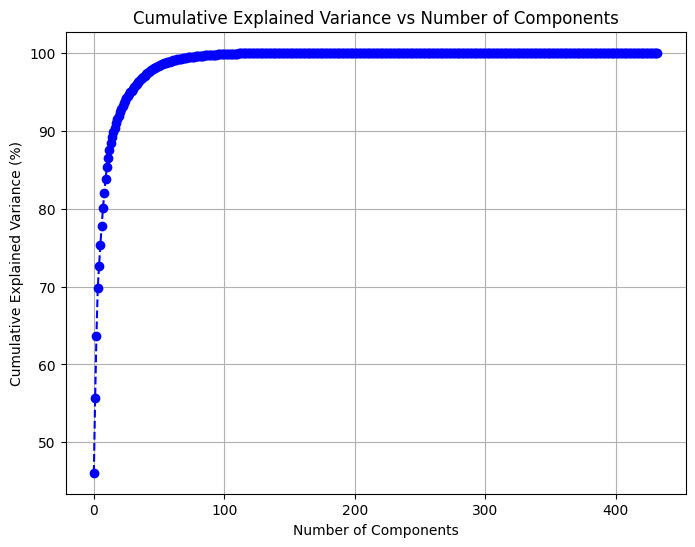

Number of components to retain for 95% explained variance: 47


array([ 46.10375335,  55.6656993 ,  63.69896624,  69.83217339,
        72.62631742,  75.36108075,  77.78790529,  80.06209345,
        81.99974907,  83.85868109,  85.30187169,  86.46667857,
        87.49605112,  88.38839908,  89.16032299,  89.8159909 ,
        90.39378827,  90.9411861 ,  91.44209156,  91.91663617,
        92.366929  ,  92.81398102,  93.21295737,  93.56858182,
        93.86349141,  94.14059458,  94.41248082,  94.67415805,
        94.91823068,  95.14868436,  95.37567978,  95.59897112,
        95.81569893,  96.0224405 ,  96.21356813,  96.39831649,
        96.57369221,  96.74550765,  96.90314821,  97.05600135,
        97.2079731 ,  97.35569427,  97.49855899,  97.63725521,
        97.77229923,  97.89685919,  98.0019662 ,  98.09825448,
        98.19212269,  98.27550076,  98.35873177,  98.43476221,
        98.50472148,  98.57401081,  98.64078357,  98.70197914,
        98.762446  ,  98.81892059,  98.87114968,  98.92062886,
        98.96887639,  99.0160421 ,  99.06031804,  99.10

In [18]:
for f in df_train.drop('isFraud', axis=1).columns:
     if df_train[f].dtype=='object': 
         lbl = LabelEncoder()
         lbl.fit(df_train[f].values)
         df_train[f] = lbl.transform(list(df_train[f].values))
         
df_train.fillna(-999, inplace=True)

df_train_numeric = df_train.select_dtypes(include=['number'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train_numeric)

# Compute the covariance matrix
cov_matrix = np.cov(X_scaled.T)  # Transpose to match the correct shape

# Calculate eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and their corresponding eigenvectors
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Total variance
tot = sum(eig_vals)

# Explained variance per component
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]

# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(8, 6))
plt.plot(cum_var_exp, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.show()

# Optionally, decide how many components you want to retain, for example, you might choose 95% explained variance
n_components = np.argmax(cum_var_exp >= 98) + 1  # +1 because of 0-indexing
print(f"Number of components to retain for 95% explained variance: {n_components}")
cum_var_exp


In [20]:
for f in df_train.drop('isFraud', axis=1).columns:
     if df_train[f].dtype=='object': 
         lbl = LabelEncoder()
         lbl.fit(df_train[f].values)
         df_train[f] = lbl.transform(list(df_train[f].values))

df_train.fillna(-999, inplace=True)

X_train = df_train.select_dtypes(include=['number']).drop(columns=['isFraud'])
y_train = df_train['isFraud']  # This is the target variable

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA and specify number of components (optional)
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best parameters found by GridSearchCV: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best accuracy score: 0.9741
Accuracy of the tuned KNN model: 0.9761

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.80      0.42      0.55      4133

    accuracy                           0.98    118108
   macro avg       0.89      0.71      0.77    118108
weighted avg       0.97      0.98      0.97    118108



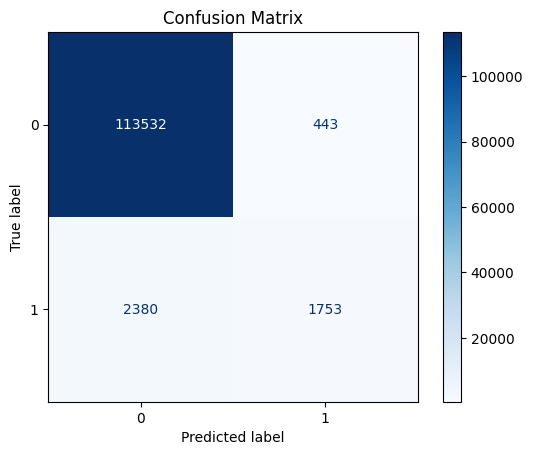

In [21]:
knn = KNeighborsClassifier()
# Step 2: Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Step 3: Set up GridSearchCV with cross-validation (you can adjust cv depending on your machine)
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)

# Step 4: Fit the GridSearchCV with the training data (using PCA-transformed data)
grid_search.fit(X_train_pca, y_train_final)

# Step 5: Retrieve and display the best parameters and best score
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print(f"Best accuracy score: {grid_search.best_score_:.4f}")

best_knn = grid_search.best_estimator_

# Evaluate the tuned KNN model on the validation set
y_val_pred = best_knn.predict(X_val_pca)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy of the tuned KNN model: {accuracy:.4f}")

# Show detailed classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(cmap='Blues')  # 'Blues' colormap for better readability
plt.title('Confusion Matrix')
plt.show()
